In [25]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2 as cv

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Load and Transform Data

In [3]:
dataset = "../input/fire-dataset/fire_dataset"
## Check whole format from all images
for root, dirs, files in os.walk(dataset):
    print(root, end="\n")
    #print(root.split('/')[-1], "::+++++++++++++", len(files))
    lol = set()
    if len(files)>0:
        for f in files:
            lol.add(f.split(".")[-1])
print(lol)

../input/fire-dataset/fire_dataset
../input/fire-dataset/fire_dataset/non_fire_images
../input/fire-dataset/fire_dataset/fire_images
{'png'}


# Placing data into a Dataframe

In [4]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

#---------------------------------------------------------------------------------
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
'''labels = []
for x in filepaths:
    #print(os.path.split(os.path.split(x)[0])[1])
    labels.append(os.path.split(os.path.split(x)[0])[1])
    break'''
#---------------------------------------------------------------------------------
# Create DataFrame
image_df = pd.DataFrame(columns=["filepaths", "labels"])
image_df['filepaths'] = filepaths
image_df['labels'] = labels

image_df['filepaths']=image_df['filepaths'].astype(str)
image_df.tail()

,filepaths,labels
994,../input/fire-dataset/fire_dataset/fire_images...,fire_images
995,../input/fire-dataset/fire_dataset/fire_images...,fire_images
996,../input/fire-dataset/fire_dataset/fire_images...,fire_images
997,../input/fire-dataset/fire_dataset/fire_images...,fire_images
998,../input/fire-dataset/fire_dataset/fire_images...,fire_images


In [ ]:
image_df.info()

# Visualizing images from the dataset

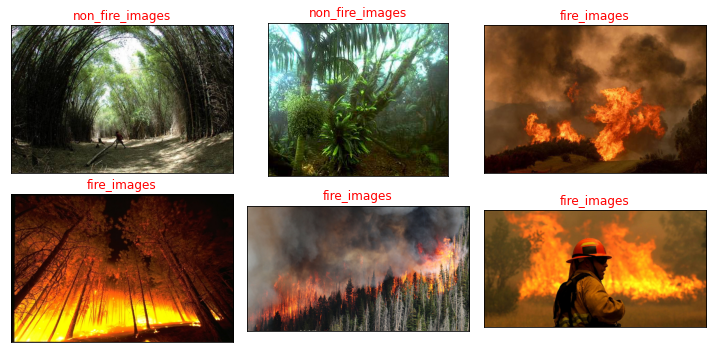

In [5]:
import matplotlib.image as mpimg

# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, ax = plt.subplots(2, 3, figsize=(10, 5), 
                       subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(ax.flat):
    image = Image.open(image_df.filepaths[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.labels[random_index[i]], color='red')
    
plt.tight_layout()
plt.show()

# Data Preprocessing

In [7]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [8]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
#--------------------------------------------------------------------------
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 640 validated image filenames belonging to 2 classes.
Found 159 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


# PreTrain Model

In [10]:
# Load the PRETRAINED MODEL
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

for layer in pretrained_model.layers:
    layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


# Training the model

In [11]:
# Input Layer to...
#inputs = pretrained_model.input   # shape=(None, 224, 224, 3)

# add Resize Layer
#x = layers.experimental.preprocessing.Resizing(224, 224)(inputs)
#x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# global_average_pooling to...
x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)

#model.summary()

In [12]:
# Create checkpoint callback
checkpoint_path = "fires_classif_model"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy", # Cause we used accuracy in compiles->metrics
                                      save_best_only=True)

In [13]:
# Setup EarlyStopping callback
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs 
                                                            # in a row, stop training

In [14]:
# Compile...
model.compile(
    optimizer = Adam(0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# Training / Fit...
history = model.fit(
    train_images,
    steps_per_epoch = len(train_images),
    validation_data = val_images,
    validation_steps = len(val_images),
    epochs = 100,
    callbacks = [
        early_stopping,
        #create_tensorboard_callback("training_logs", 
        #                           "fire_classification"),
        checkpoint_callback,
    ]
)

Epoch 1/100
20/20 [==============================] - 48s 2s/step - loss: 0.4747 - accuracy: 0.7359 - val_loss: 0.2168 - val_accuracy: 0.9245
Epoch 2/100
20/20 [==============================] - 33s 2s/step - loss: 0.1771 - accuracy: 0.9516 - val_loss: 0.1221 - val_accuracy: 0.9560
Epoch 3/100
20/20 [==============================] - 33s 2s/step - loss: 0.1176 - accuracy: 0.9578 - val_loss: 0.0941 - val_accuracy: 0.9560
Epoch 4/100
20/20 [==============================] - 34s 2s/step - loss: 0.0852 - accuracy: 0.9766 - val_loss: 0.0782 - val_accuracy: 0.9623
Epoch 5/100
20/20 [==============================] - 34s 2s/step - loss: 0.0605 - accuracy: 0.9891 - val_loss: 0.0697 - val_accuracy: 0.9686
Epoch 6/100
20/20 [==============================] - 34s 2s/step - loss: 0.0593 - accuracy: 0.9844 - val_loss: 0.0643 - val_accuracy: 0.9686
Epoch 7/100
20/20 [==============================] - 33s 2s/step - loss: 0.0473 - accuracy: 0.9906 - val_loss: 0.0606 - val_accuracy: 0.9686
Epoch 8/100
2

In [15]:
# Saving PreTrained Model
model.save('Fire_Classification_mobilenetv2.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Model Evaluation
The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

**Precision(P)**: 
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.

<center>$P=TP/(TP+FP)$</center>

**Recall(R)**: 
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.
<center>$R=TP/(TP+FN)$</center>

**F1 score(F1)**: 
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.
<center>$F1=2 * (TP * FP)/(TP+FP)$</center>



In [16]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize =(10,4))
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure(figsize =(10,4))
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

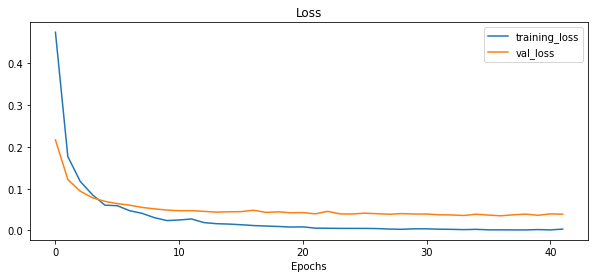

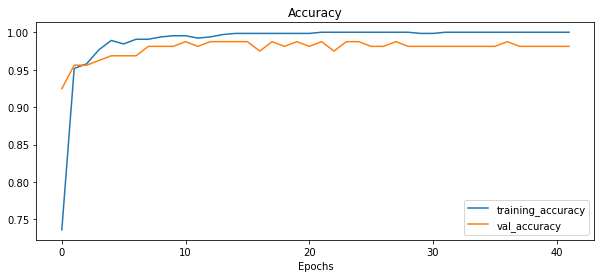

In [17]:
# Visualizing loss curves
plot_loss_curves(history)

In [18]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.07264
Test Accuracy: 98.50%


# Making predictions on the Test Data

In [20]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['fire_images', 'fire_images', 'non_fire_images', 'fire_images', 'fire_images']


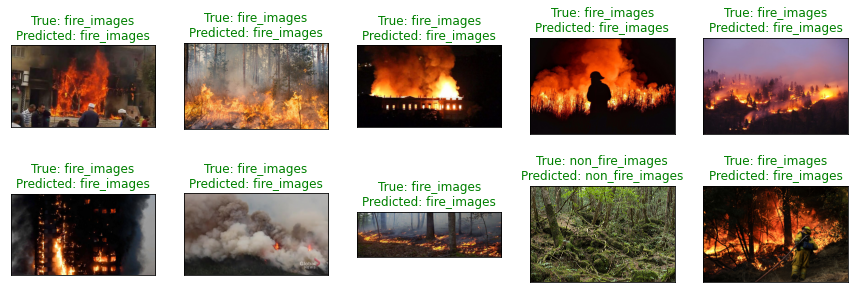

<Figure size 432x288 with 0 Axes>

In [21]:
# Display random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(2, 5, figsize=(15, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.filepaths.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.labels.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.labels.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()
plt.show()

In [22]:
y_test = list(test_df.labels)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    fire_images       0.98      1.00      0.99       158
non_fire_images       1.00      0.93      0.96        42

       accuracy                           0.98       200
      macro avg       0.99      0.96      0.98       200
   weighted avg       0.99      0.98      0.98       200



# Confusion Matrix

In [26]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


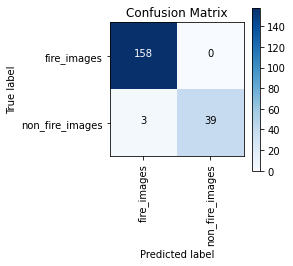

In [29]:
make_confusion_matrix(y_test, pred, list(labels.values()), figsize=(3, 3))